<h1 style="text-align:center;">IDFC FAME 2.0 ROUND 2 CODES</h1>


<h2 style="text-align:center;">Exploratory Data Analysis</h2>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
df = pd.read_csv('Training data file.csv', index_col='Customer_No')
df_test = pd.read_csv('Validation Data file.csv', index_col='Customer_No')
df1 = df.copy()
col = df.columns

In [3]:
df.head()

,N_Default_L3m,Branch_Code,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,Max_Ratio_OC_Pending_POS,N_PosBkt_L3m,CoAp_Income,Ever_Default_L12M,Perc_Paymode_Online,...,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,Total_Field_Trails,Total_Resolved,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
Customer_No,,,,,,,,,,,,,,,,,,,,,
1,3,61749,38,100.0,5,NaN,0.0,NaN,Yes,0.285714,...,1977,19.0,0.750,46,NaN,NaN,0,5527.0,15,0
2,1,30831,68,100.0,1,NaN,0.0,NaN,Yes,0.000000,...,1990,2.0,0.500,33,NaN,NaN,0,12104.0,2,0
3,1,56708,39,50.0,-3,NaN,0.0,NaN,Yes,0.200000,...,1995,25.0,1.000,28,NaN,0.0,1,153179.0,8,0
4,0,43551,76,NaN,0,NaN,0.0,NaN,No,0.000000,...,1997,0.0,NaN,26,NaN,NaN,2,181589.0,6,0
5,3,15287,23,33.0,11,NaN,0.0,NaN,Yes,0.250000,...,1995,19.0,0.375,28,NaN,NaN,1,10661.0,8,0


Function for Missing values in each column

In [4]:
def missingdata_percentage(df, per=0):
    missing = pd.DataFrame(columns=['category','percentage'])
    for col in df.columns:
        if df[col].isna().values.any():
            count = df[col].isna().sum()
            percentage = 100*df[col].isna().sum()/df.shape[0]
            if percentage>=per:
              missing = missing.append({'category' : col, 'percentage' : percentage, 'count' : int(count)}, ignore_index=True)
    missing.sort_values(by=['percentage'], inplace=True, ascending=False)
    return missing

In [5]:
train_data_Miss = missingdata_percentage(df)
train_data_Miss

,category,percentage,count
3,CoAp_Income,94.931879,77135.0
1,Max_Ratio_OC_Pending_POS,89.407160,72646.0
6,Total_Field_Trails,67.335360,54712.0
7,Total_Resolved,61.911560,50305.0
5,Perc_Paymode_Cheq_Fail,28.893702,23477.0
0,Max_Perc_Def_Chg_Pending,25.941196,21078.0
2,N_PosBkt_L3m,6.569604,5338.0
8,Max_Loan_Balance_Others,0.419677,341.0
4,Max_DPD_L3m,0.299066,243.0


In [115]:
test_data_Miss = missingdata_percentage(df_test)
test_data_Miss

,category,percentage,count
3,CoAp_Income,95.060045,28576.0
1,Max_Ratio_OC_Pending_POS,89.551246,26920.0
6,Total_Field_Trails,67.619174,20327.0
7,Total_Resolved,62.117029,18673.0
5,Perc_Paymode_Cheq_Fail,28.638435,8609.0
0,Max_Perc_Def_Chg_Pending,24.513489,7369.0
2,N_PosBkt_L3m,6.157480,1851.0
4,Max_DPD_L3m,0.392535,118.0
8,Max_Loan_Balance_Others,0.372576,112.0


In [116]:
df['Target_Flag'].value_counts()

0    71469
1     9784
Name: Target_Flag, dtype: int64

### Let's start filling missing values in descending order.

### Handling "CoAp_Income"
* Upon closer inspection "CoAp_Income"(income of co-applicant) column looks like a optional entry and hence so many missing values. 95% of them are missing values so they won't add any value to the data hence we can drop this column.




### Handling "Max_Ratio_OC_Pending_POS"

In [117]:
count = df['Max_Ratio_OC_Pending_POS'].value_counts()[0]
count

249

* Next "Max_Ratio_OC_Pending_POS" column also have 90% of missing values, most of these values are between 0 and 1.<br>
 -->Although there are 249 0's in dataset so they might correspond to people who paid their overdue charges.<br>--> And remaining null values most likely means these people didn't had any overdue charges to begin with. <br>
 -->So its a good idea to assume these values to be zero.<br>
-->But let's analyze further.

In [118]:
#Let's see distribution of target variable when Max_Ratio_OC_Pending_POS is 0.
df['Target_Flag'][df['Max_Ratio_OC_Pending_POS'] == 0].value_counts()

0    195
1     54
Name: Target_Flag, dtype: int64

In [119]:
# 22% of them corresponds to default customer

# Now lets see distribution of target when they are null.
df['Target_Flag'][df['Max_Ratio_OC_Pending_POS'].isna()].value_counts()

0    65165
1     7481
Name: Target_Flag, dtype: int64

In [120]:
# 10% of missing values have defaulted customers.

# Now lets see what percent of people have overdue charges pending and they defaulted.
cnt_with_oc_and_default = df[(df['Max_Ratio_OC_Pending_POS'] > 0 ) & (df['Target_Flag']== 1)].shape[0]
default_cnt = df[(df['Target_Flag']== 1)].shape[0]
oc_more_than_zero = df[(df['Max_Ratio_OC_Pending_POS'] > 0)].shape[0]


In [121]:
ratio_of_oc_and_default = (cnt_with_oc_and_default/oc_more_than_zero)
default_cnt, oc_more_than_zero, cnt_with_oc_and_default, ratio_of_oc_and_default

(9784, 8358, 2249, 0.26908351280210574)

From above data we see that 27% of people who have overdue charges have defaulted, that means other 73% of people are not defaulters.<br>
Also 0 doesn't necessarily confirms that person will not commit default. <br>
Thus we know that we cannot replace null value with 0, instead we can change them to another categorical variable and work on that. 

#### Now lets examine null values of "Total_field_trials" and "Total_resolved"

In [122]:
'''def find_col_relation_with_target(df, col, value = 0):
    Valuecount_col_is_value = df['Target_Flag'][df[col] == value].value_counts()
    Valuecount_col_is_null = df['Target_Flag'][df[col].isna()].value_counts()
    null_without_default_last_12_month = df[col].isna()[df['Ever_Default_L12M'] == 'No'].sum()
    null_with_default_last_12_month = df[col].isna()[df['Ever_Default_L12M'] == 'Yes'].sum()
    null_without_default_last_3_month = df[col].isna()[df['N_Default_L3m'] == 'No'].sum()
    null_with_default_last_3_month = df[col].isna()[df['N_Default_L3m'] == 'Yes'].sum()
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", Valuecount_col_is_value)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS NULL VALUES:", Valuecount_col_is_null)
    print("NULL VALUES DISTRIBUTION WITHOUT DEFAULT IN LAST ", null_without_default_last_12_month)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_with_default_last_12_month)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_without_default_last_3_month)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_with_default_last_3_month)'''

'def find_col_relation_with_target(df, col, value = 0):\n    Valuecount_col_is_value = df[\'Target_Flag\'][df[col] == value].value_counts()\n    Valuecount_col_is_null = df[\'Target_Flag\'][df[col].isna()].value_counts()\n    null_without_default_last_12_month = df[col].isna()[df[\'Ever_Default_L12M\'] == \'No\'].sum()\n    null_with_default_last_12_month = df[col].isna()[df[\'Ever_Default_L12M\'] == \'Yes\'].sum()\n    null_without_default_last_3_month = df[col].isna()[df[\'N_Default_L3m\'] == \'No\'].sum()\n    null_with_default_last_3_month = df[col].isna()[df[\'N_Default_L3m\'] == \'Yes\'].sum()\n    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", Valuecount_col_is_value)\n    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS NULL VALUES:", Valuecount_col_is_null)\n    print("NULL VALUES DISTRIBUTION WITHOUT DEFAULT IN LAST ", null_without_default_last_12_month)\n    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_with_default_last_12_month)\n    

In [123]:
col = df.columns
col

Index(['N_Default_L3m', 'Branch_Code', 'Max_Utilization',
       'Max_Perc_Def_Chg_Pending', 'N_Family_Member',
       'Max_Ratio_OC_Pending_POS', 'N_PosBkt_L3m', 'CoAp_Income',
       'Ever_Default_L12M', 'Perc_Paymode_Online', 'Perc_Repay_Fail',
       'Birth_Year', 'Max_DPD_L3m', 'Perc_Paymode_Cheq_Fail', 'Age',
       'Total_Field_Trails', 'Total_Resolved', 'N_Enq_L9m',
       'Max_Loan_Balance_Others', 'N_WorkEx_Yr', 'Target_Flag'],
      dtype='object')

In [124]:
#Count of null values:
df['Total_Field_Trails'].isna().sum(), df['Total_Resolved'].isna().sum()

(54712, 50305)

In [125]:
# Distribution of null values:
df['Total_Field_Trails'].value_counts(), df['Total_Resolved'].value_counts()

(0.0    18186
 1.0     5993
 2.0     1725
 3.0      567
 4.0       49
 5.0       13
 6.0        6
 9.0        1
 7.0        1
 Name: Total_Field_Trails, dtype: int64,
 1.0    15255
 2.0     7032
 3.0     4881
 0.0     3780
 Name: Total_Resolved, dtype: int64)

In [126]:
# Checking occurences of null values in both the fields simultaneously:
checking_common_occurences = df[(df['Total_Field_Trails'].isna() ) & (df['Total_Resolved'].isna())].shape[0]
checking_common_occurences

50305

* Now since there a lot of null values we can solve them using some common sense.
* First if there are lots of null amount of "Total_Field_Trails" it strongly indicates 0 field visits.
* Also above code shows that all the null values in "Total_Resolved" is when "Total_Field_Trails" is null as well.
* But in "Total_Resolved" column it doesn't tells us if Customer was visited or not.
* So we can take all the null value from total_resolved column as another value, let's say "not_visited".

In [127]:
correlation = df['Total_Field_Trails'].corr(df['Total_Resolved'])
correlation

0.17398498482556185

### Now lets look at the 'Perc_Paymode_Cheq_Fail' column.

<Axes: >

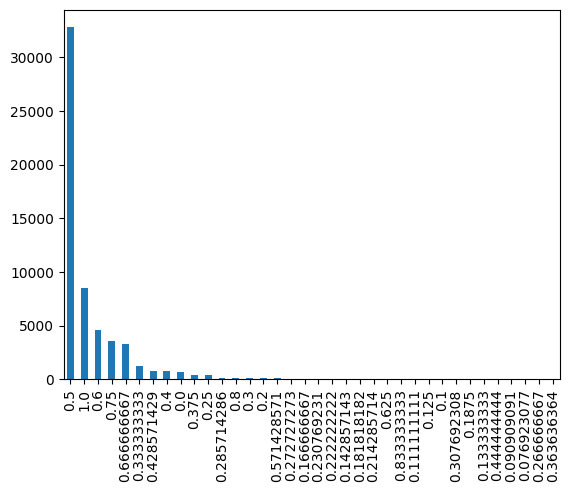

In [128]:
def_chg_perc = df['Perc_Paymode_Cheq_Fail'].value_counts()[df['Perc_Paymode_Cheq_Fail'].value_counts() >= 0]
def_chg_perc.plot(kind='bar')

In [129]:
df['Perc_Paymode_Cheq_Fail'].value_counts()[0.0]

710

* We see that some of the values are 0 thus it means that customer with null values have never attempted to pay via cheque.

Although there is ambiguity its safe to assume 0 inplace of null values.

---

Now lets find some relation between Payment methods and payment failures.

Now lets explore "Max_Perc_Def_Chg_Pending" column:
1. Firstly this column signifies the maximum percentage of default charges pending.

Number of null values:

In [130]:
null_perc_def_chg = df['Max_Perc_Def_Chg_Pending'].isna().sum()
null_perc_def_chg

21078

Null values may mean that person never had any default charge. So lets check amount of customer with default in past 12 months and Max_Perc_Def_Chg_Pending as null.


In [131]:
null_without_default = df['Max_Perc_Def_Chg_Pending'].isna()[df['Ever_Default_L12M'] == 'No'].sum()
null_with_default = df['Max_Perc_Def_Chg_Pending'].isna()[df['Ever_Default_L12M'] == 'Yes'].sum()
null_with_default/null_perc_def_chg, null_without_default/null_perc_def_chg

(0.19944966315589716, 0.8005503368441028)

We can see that customer without default in last 12 months have 80% of the null values and rest does have default.
It is safe to assume that null values means customer never had any default in last 12 months.<br>
----> So we can take null values to be another category.

<Axes: >

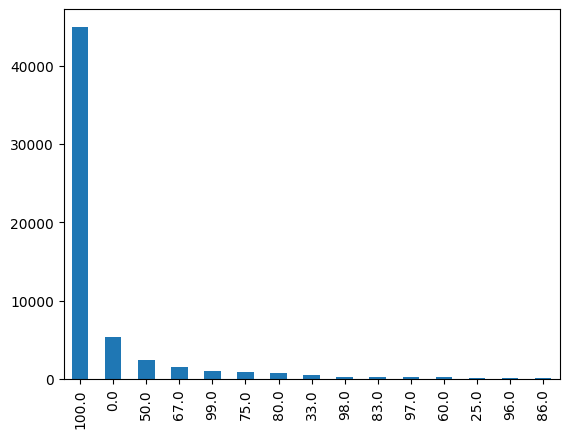

In [132]:
def_chg_perc = df['Max_Perc_Def_Chg_Pending'].value_counts()[df['Max_Perc_Def_Chg_Pending'].value_counts() >= 100]
def_chg_perc.plot(kind='bar')

Now lets handle "N_Default_L3m" column missing values: 

In [133]:
df['N_PosBkt_L3m'].isna().sum()

5338

In [134]:
df['N_PosBkt_L3m'].value_counts()

0.0    74985
1.0      857
2.0       72
3.0        1
Name: N_PosBkt_L3m, dtype: int64

In [135]:
df['N_PosBkt_L3m'][df['Target_Flag'] == 0].value_counts()

0.0    66176
1.0      587
2.0       47
3.0        1
Name: N_PosBkt_L3m, dtype: int64

In [136]:
df['N_PosBkt_L3m'][df['Target_Flag'] == 1].value_counts()

0.0    8809
1.0     270
2.0      25
Name: N_PosBkt_L3m, dtype: int64

In [137]:
df['Target_Flag'][df['N_PosBkt_L3m'].isna()].value_counts()

0    4658
1     680
Name: Target_Flag, dtype: int64

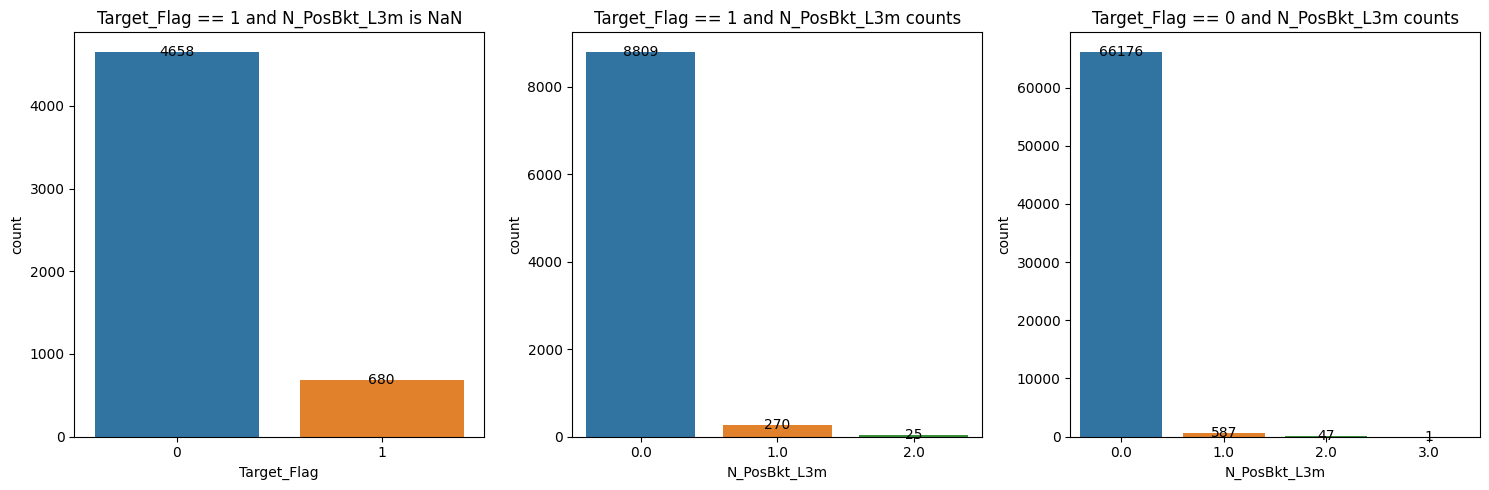

In [138]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Target_Flag == 1 and N_PosBkt_L3m is NaN
sns.countplot(data=df[df['N_PosBkt_L3m'].isna()], x='Target_Flag', ax=axes[0])
axes[0].set_title('Target_Flag == 1 and N_PosBkt_L3m is NaN')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Plot 2: Target_Flag == 1 and N_PosBkt_L3m counts
sns.countplot(data=df[df['Target_Flag'] == 1], x='N_PosBkt_L3m', ax=axes[1])
axes[1].set_title('Target_Flag == 1 and N_PosBkt_L3m counts')
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Plot 3: Target_Flag == 0 and N_PosBkt_L3m counts
sns.countplot(data=df[df['Target_Flag'] == 0], x='N_PosBkt_L3m', ax=axes[2])
axes[2].set_title('Target_Flag == 0 and N_PosBkt_L3m counts')
for p in axes[2].patches:
    axes[2].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



We see that for missing values defaults are 680 and not defaults are 4658. Which is a proportionate distribution with whole training data.
* It may also correspond to people who recently took the loan. (Less than 3 months ago)<br>
 Anyway since it merely affects 6% of the data so we can test it out with imputing 0, if needed we can try some other methods.
---

Now remaining two columns with missing values are:
1. Max_DPD_L3m
2. Max_Loan_Balance_Others

In [139]:
df['Max_DPD_L3m'].isna().sum()

243

In [140]:
df['Target_Flag'][df['Max_DPD_L3m'].isna()].value_counts()

0    219
1     24
Name: Target_Flag, dtype: int64

In [141]:
value_counts_grouped = df.groupby(['Max_DPD_L3m', 'Target_Flag']).size().reset_index(name='count')
value_counts_grouped

,Max_DPD_L3m,Target_Flag,count
0,0.0,0,23603
1,0.0,1,1913
2,1.0,0,917
3,1.0,1,90
4,2.0,0,952
5,2.0,1,88
6,3.0,0,1143
7,3.0,1,73
8,4.0,0,1772
9,4.0,1,138


In [142]:
df['Target_Flag'][df['Max_DPD_L3m'] == 0.0].value_counts()

0    23603
1     1913
Name: Target_Flag, dtype: int64

In [143]:
df['Target_Flag'][df['Max_DPD_L3m'] > 0.0].value_counts()

0    47647
1     7847
Name: Target_Flag, dtype: int64

We see that about 7.5% of customer defaulted when their days delay in payment was 0.
Also about 14.12% of people defaulted otherwise.

One interesting way to solve this problem would be imputing 0.0 in case target flag is 0 and  15.0 or higher when target flag is 1.

<Axes: >

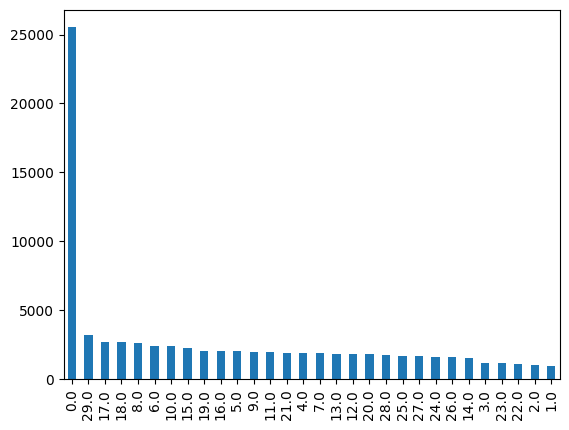

In [144]:
df['Max_DPD_L3m'].value_counts().plot(kind='bar')

In [145]:
from random import randint

df['Max_DPD_L3m'].fillna(0.0 if (df['Target_Flag'] == 0).all() else np.random.randint(15, 30), inplace=True)


Now for column "Max_Loan_Balance_Others":

In [146]:
df['Max_Loan_Balance_Others'].isna().sum()

341

In [147]:
df['Target_Flag'][df['Max_Loan_Balance_Others'].isna()].value_counts()

0    298
1     43
Name: Target_Flag, dtype: int64

In [148]:
df['Max_Loan_Balance_Others'].describe()

count    8.091200e+04
mean     1.462583e+05
std      4.509210e+05
min     -5.425000e+03
25%      9.992000e+03
50%      1.999900e+04
75%      1.100060e+05
max      6.553632e+07
Name: Max_Loan_Balance_Others, dtype: float64

We see there are some negative values in this column lets make them positive.

In [149]:
df['Max_Loan_Balance_Others'] = df['Max_Loan_Balance_Others'].abs()

In [150]:
df['Max_Loan_Balance_Others'].describe()

count    8.091200e+04
mean     1.462589e+05
std      4.509208e+05
min      0.000000e+00
25%      9.992000e+03
50%      1.999900e+04
75%      1.100060e+05
max      6.553632e+07
Name: Max_Loan_Balance_Others, dtype: float64

Let's compare different percentile with Target_Flag

In [151]:
df['Target_Flag'][df['Max_Loan_Balance_Others']<9992].value_counts()

0    17801
1     2403
Name: Target_Flag, dtype: int64

12%, 12.5%, 12.42%, 10.9%
12.32, 

In [152]:
df['Target_Flag'][df['Max_Loan_Balance_Others']<19999].value_counts()

0    35394
1     5036
Name: Target_Flag, dtype: int64

In [153]:
df['Target_Flag'][(9992 < df['Max_Loan_Balance_Others']) & (df['Max_Loan_Balance_Others'] > 19999)].value_counts()

0    35682
1     4686
Name: Target_Flag, dtype: int64

In [154]:
df['Target_Flag'][(19999 < df['Max_Loan_Balance_Others']) & (df['Max_Loan_Balance_Others'] > 110006)].value_counts()


0    18024
1     2204
Name: Target_Flag, dtype: int64

In [155]:
df['Target_Flag'][df['Max_Loan_Balance_Others']>110006].value_counts()

0    18024
1     2204
Name: Target_Flag, dtype: int64

In [156]:
df['Target_Flag'][df['Max_Loan_Balance_Others']== 0.0].value_counts()

0    1787
1     212
Name: Target_Flag, dtype: int64

1. There are zeroes in this column which suggest that column includes people with zero loan. <br>
2. There are very less null values it may quite simply mean that these customer doesn't even have a bank account in other banks.
3. Distribution of target flag over different range of percentile is more or less similar.
4. Moreover distribution of target flag is also quite similar in case when loan balance with others is 0.

 -----> In any case filling these null values with 0 will do no harm.

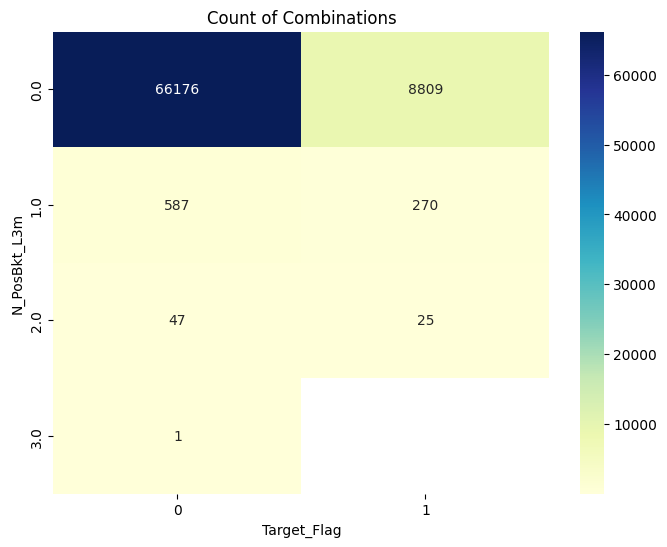

In [157]:
value_counts_grouped = df.groupby(['N_PosBkt_L3m', 'Target_Flag']).size().reset_index(name='count')

pivot_table = value_counts_grouped.pivot('N_PosBkt_L3m', 'Target_Flag', 'count')


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Count of Combinations")
plt.show()

In [158]:
col

Index(['N_Default_L3m', 'Branch_Code', 'Max_Utilization',
       'Max_Perc_Def_Chg_Pending', 'N_Family_Member',
       'Max_Ratio_OC_Pending_POS', 'N_PosBkt_L3m', 'CoAp_Income',
       'Ever_Default_L12M', 'Perc_Paymode_Online', 'Perc_Repay_Fail',
       'Birth_Year', 'Max_DPD_L3m', 'Perc_Paymode_Cheq_Fail', 'Age',
       'Total_Field_Trails', 'Total_Resolved', 'N_Enq_L9m',
       'Max_Loan_Balance_Others', 'N_WorkEx_Yr', 'Target_Flag'],
      dtype='object')

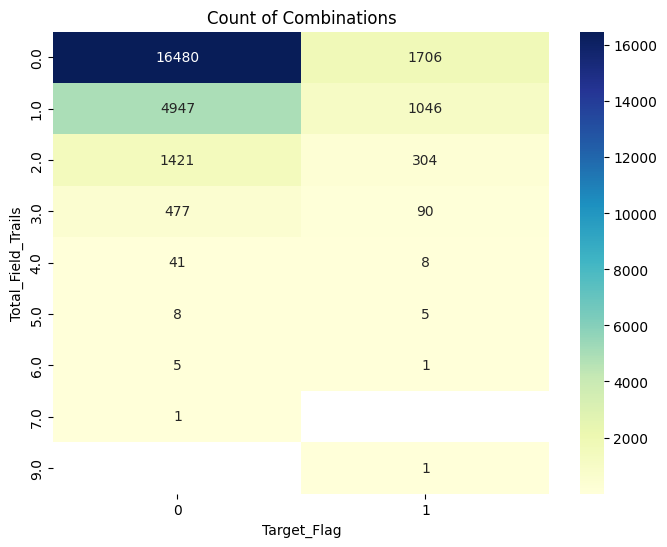

In [159]:
value_counts_grouped = df.groupby(['Total_Field_Trails', 'Target_Flag']).size().reset_index(name='count')

pivot_table = value_counts_grouped.pivot('Total_Field_Trails', 'Target_Flag', 'count')


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Count of Combinations")
plt.show()

In [160]:
def value_wise_defaulter_percentage(df, col):
    new_df = pd.DataFrame(columns=['Value', 'Percentage of Defaulter'])
    
    for value in df[col]:
        default_cnt = df[(df[col] == value) & (df['Target_Flag']== 1)].shape[0]
        total_cnt = df[df[col] == value].shape[0]
        new_df = new_df.append({'Value' : value , 'Percentage of Defaulter' : (default_cnt*100/total_cnt)}, ignore_index=True)
    return new_df.sort_values(by='Percentage of Defaulter', ascending=False)

In [161]:
filtered_df = df[(df['Max_Ratio_OC_Pending_POS'] >= 0) & (df['Max_Ratio_OC_Pending_POS'] <= 1)]


<Axes: >

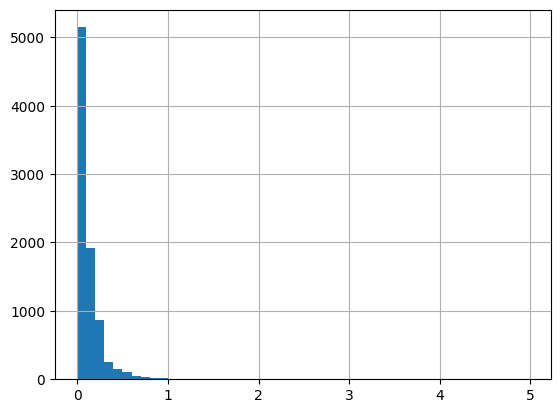

In [162]:
df['Max_Ratio_OC_Pending_POS'].hist(bins=50)

In [163]:
count = df['Max_Ratio_OC_Pending_POS'].value_counts()
count

0.000000    249
0.255264     37
0.110603     25
0.088956     21
0.106227     20
           ... 
0.265586      1
0.076857      1
0.024070      1
0.217585      1
0.043705      1
Name: Max_Ratio_OC_Pending_POS, Length: 6182, dtype: int64

---

Identifying Numerical Datatypes Columns

In [164]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

df[numerical_features].head()

Number of numerical variables:  20


,N_Default_L3m,Branch_Code,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,Max_Ratio_OC_Pending_POS,N_PosBkt_L3m,CoAp_Income,Perc_Paymode_Online,Perc_Repay_Fail,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,Total_Field_Trails,Total_Resolved,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
Customer_No,,,,,,,,,,,,,,,,,,,,
1,3,61749,38,100.0,5,NaN,0.0,NaN,0.285714,0.428571,1977,19.0,0.750,46,NaN,NaN,0,5527.0,15,0
2,1,30831,68,100.0,1,NaN,0.0,NaN,0.000000,0.200000,1990,2.0,0.500,33,NaN,NaN,0,12104.0,2,0
3,1,56708,39,50.0,-3,NaN,0.0,NaN,0.200000,0.200000,1995,25.0,1.000,28,NaN,0.0,1,153179.0,8,0
4,0,43551,76,NaN,0,NaN,0.0,NaN,0.000000,0.000000,1997,0.0,NaN,26,NaN,NaN,2,181589.0,6,0
5,3,15287,23,33.0,11,NaN,0.0,NaN,0.250000,0.250000,1995,19.0,0.375,28,NaN,NaN,1,10661.0,8,0


Finding Rest of the Columns

In [165]:
for col in df.columns:
    if col not in numerical_features:
        print(col)

Ever_Default_L12M


In [166]:
df['Ever_Default_L12M'].unique()

array(['Yes', 'No'], dtype=object)

Changing "Yes" and "No" to 0 and 1 respectively

In [167]:
df['Ever_Default_L12M'] = df['Ever_Default_L12M'].replace({'Yes': 1, 'No': 0})

In [168]:
def value_wise_defaulter_percentage(df, col):
    new_df = pd.DataFrame(columns=['Value', 'Percentage of Defaulter'])
    
    for value in df[col].unique():
        default_cnt = df[(df[col] == value) & (df['Target_Flag']== 1)].shape[0]
        total_cnt = df[df[col] == value].shape[0]
        new_df = new_df.append({'Value' : value , 'Percentage of Defaulter' : (default_cnt*100/total_cnt)}, ignore_index=True)
    return new_df.sort_values(by='Percentage of Defaulter', ascending=False)

In [169]:
df.isna().sum()

N_Default_L3m                   0
Branch_Code                     0
Max_Utilization                 0
Max_Perc_Def_Chg_Pending    21078
N_Family_Member                 0
Max_Ratio_OC_Pending_POS    72646
N_PosBkt_L3m                 5338
CoAp_Income                 77135
Ever_Default_L12M               0
Perc_Paymode_Online             0
Perc_Repay_Fail                 0
Birth_Year                      0
Max_DPD_L3m                     0
Perc_Paymode_Cheq_Fail      23477
Age                             0
Total_Field_Trails          54712
Total_Resolved              50305
N_Enq_L9m                       0
Max_Loan_Balance_Others       341
N_WorkEx_Yr                     0
Target_Flag                     0
dtype: int64

In [170]:
df['Total_Resolved'].value_counts()

1.0    15255
2.0     7032
3.0     4881
0.0     3780
Name: Total_Resolved, dtype: int64

In [171]:
df['Total_Resolved'].fillna('None', inplace= True)


In [172]:
df['Total_Field_Trails'].value_counts()

0.0    18186
1.0     5993
2.0     1725
3.0      567
4.0       49
5.0       13
6.0        6
9.0        1
7.0        1
Name: Total_Field_Trails, dtype: int64

In [173]:
df['Total_Field_Trails'].fillna(0, inplace= True)

In [174]:
df['Max_Ratio_OC_Pending_POS'].fillna('Others', inplace=True)

In [175]:
df['Max_Loan_Balance_Others'].fillna(0, inplace= True)

In [176]:
df['Perc_Paymode_Cheq_Fail'].fillna(0, inplace= True)

In [177]:
df.isna().sum()

N_Default_L3m                   0
Branch_Code                     0
Max_Utilization                 0
Max_Perc_Def_Chg_Pending    21078
N_Family_Member                 0
Max_Ratio_OC_Pending_POS        0
N_PosBkt_L3m                 5338
CoAp_Income                 77135
Ever_Default_L12M               0
Perc_Paymode_Online             0
Perc_Repay_Fail                 0
Birth_Year                      0
Max_DPD_L3m                     0
Perc_Paymode_Cheq_Fail          0
Age                             0
Total_Field_Trails              0
Total_Resolved                  0
N_Enq_L9m                       0
Max_Loan_Balance_Others         0
N_WorkEx_Yr                     0
Target_Flag                     0
dtype: int64

In [178]:
df['Max_Perc_Def_Chg_Pending'].fillna('None', inplace= True)

In [179]:
df['N_PosBkt_L3m'].fillna(0, inplace= True)

Now dropping some columns which are not needed


In [180]:
len(df['Branch_Code'].unique())

45722

huge no of branches so no point in exploring them.

In [181]:
df.drop(columns=['CoAp_Income', 'Branch_Code'], inplace=True)

In [182]:
df.sample(10)

,N_Default_L3m,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,Max_Ratio_OC_Pending_POS,N_PosBkt_L3m,Ever_Default_L12M,Perc_Paymode_Online,Perc_Repay_Fail,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,Total_Field_Trails,Total_Resolved,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
Customer_No,,,,,,,,,,,,,,,,,,,
17418,3,39,42.0,1,Others,0.0,1,0.111111,0.333333,2001,10.0,0.500000,22,0.0,None,1,7886.0,2,0
16266,3,86,100.0,-3,Others,0.0,1,0.125000,0.375000,1998,20.0,0.600000,25,0.0,None,0,14315.0,3,0
15678,0,64,100.0,6,Others,0.0,1,0.000000,0.000000,1997,0.0,0.000000,26,0.0,None,1,21939.0,6,0
1933,1,51,100.0,10,Others,0.0,1,0.000000,0.200000,1993,2.0,0.500000,30,0.0,None,0,8941.0,10,0
14745,1,100,100.0,-4,Others,0.0,1,0.250000,0.250000,1993,25.0,0.500000,30,0.0,None,2,11811.0,10,0
19526,0,29,75.0,11,Others,0.0,1,0.000000,0.000000,1993,0.0,0.000000,30,0.0,None,0,483275.0,10,0
25844,3,39,100.0,7,Others,0.0,1,0.250000,0.375000,1997,23.0,0.600000,26,0.0,None,2,3714.0,6,0
19822,3,52,67.0,-4,Others,0.0,1,0.000000,0.272727,1989,21.0,0.428571,34,0.0,None,0,78988.0,14,0
12497,0,44,None,1,Others,0.0,0,0.000000,0.000000,1978,0.0,0.000000,45,0.0,None,0,6459.0,3,0


In [183]:
df['Max_Perc_Def_Chg_Pending'].value_counts()

100.0    44999
None     21078
0.0       5277
50.0      2435
67.0      1532
         ...  
11.0         2
7.0          2
16.0         2
28.0         1
23.0         1
Name: Max_Perc_Def_Chg_Pending, Length: 102, dtype: int64

we see that some values are negative so lets make them positive.

In [184]:
df['N_Family_Member'] = df['N_Family_Member'].abs()

In [185]:
df['N_WorkEx_Yr'] = df['N_WorkEx_Yr'].abs()

In [186]:
df['Max_Loan_Balance_Others'] = df['Max_Loan_Balance_Others'].abs()

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81253 entries, 1 to 81253
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   N_Default_L3m             81253 non-null  int64  
 1   Max_Utilization           81253 non-null  int64  
 2   Max_Perc_Def_Chg_Pending  81253 non-null  object 
 3   N_Family_Member           81253 non-null  int64  
 4   Max_Ratio_OC_Pending_POS  81253 non-null  object 
 5   N_PosBkt_L3m              81253 non-null  float64
 6   Ever_Default_L12M         81253 non-null  int64  
 7   Perc_Paymode_Online       81253 non-null  float64
 8   Perc_Repay_Fail           81253 non-null  float64
 9   Birth_Year                81253 non-null  int64  
 10  Max_DPD_L3m               81253 non-null  float64
 11  Perc_Paymode_Cheq_Fail    81253 non-null  float64
 12  Age                       81253 non-null  int64  
 13  Total_Field_Trails        81253 non-null  float64
 14  Total_

In [188]:
df['Max_Perc_Def_Chg_Pending']

Customer_No
1        100.0
2        100.0
3         50.0
4         None
5         33.0
         ...  
81249    100.0
81250    100.0
81251    100.0
81252      0.0
81253    100.0
Name: Max_Perc_Def_Chg_Pending, Length: 81253, dtype: object

In [189]:
categorical_cols = ['N_Default_L3m','N_Family_Member', 'N_PosBkt_L3m', 'Ever_Default_L12M','Total_Field_Trails', 'Total_Resolved']

Identifying outliers:


<Axes: >

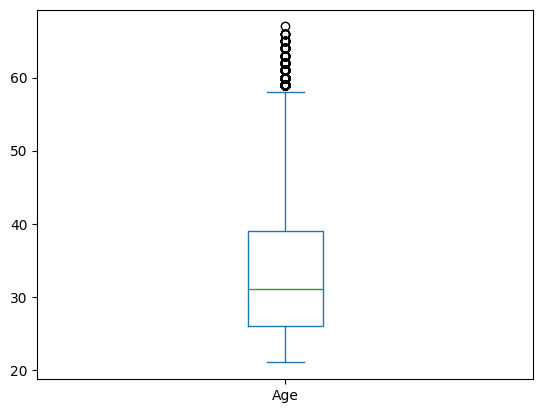

In [190]:
df['Age'].plot(kind='box')

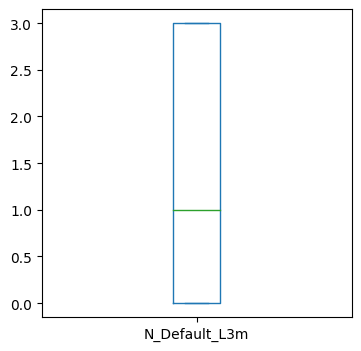

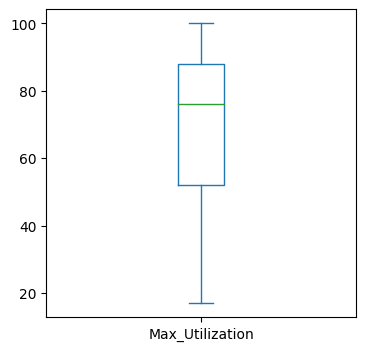

<Figure size 400x400 with 0 Axes>

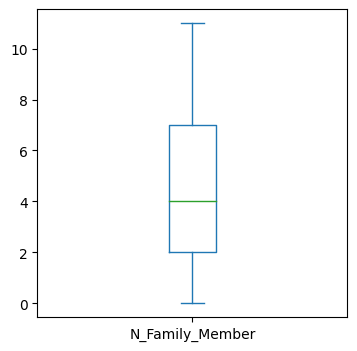

<Figure size 400x400 with 0 Axes>

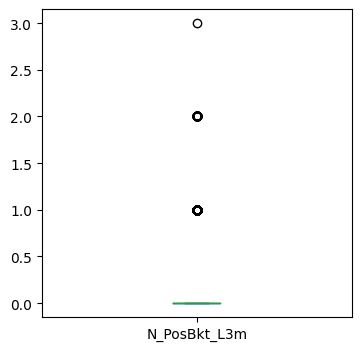

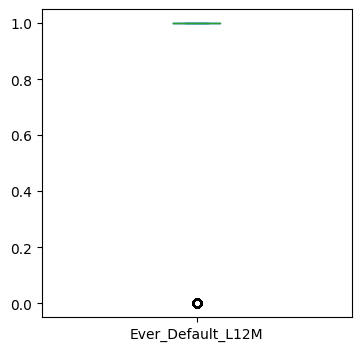

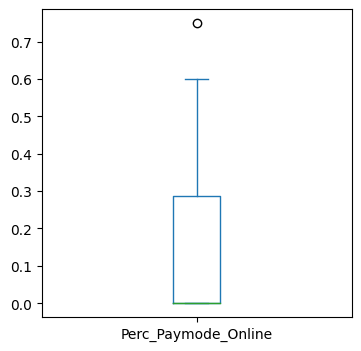

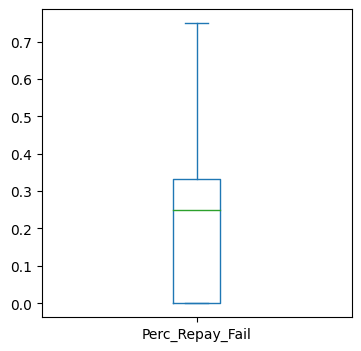

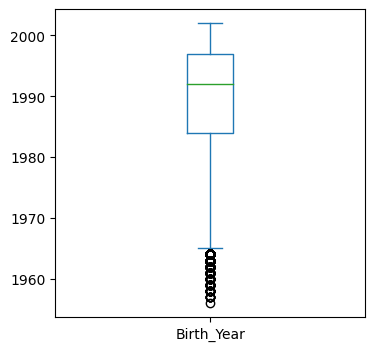

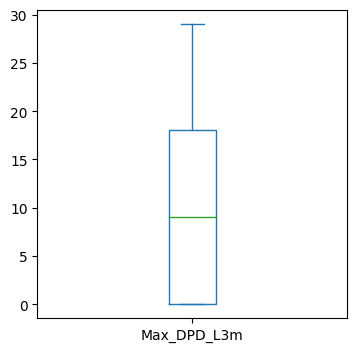

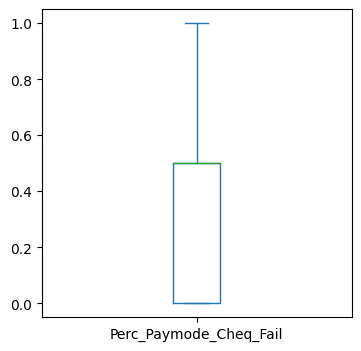

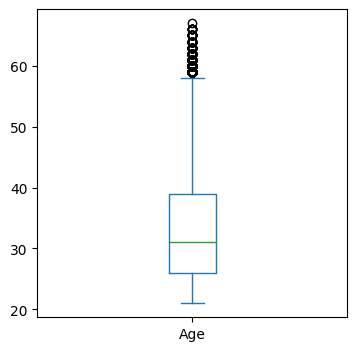

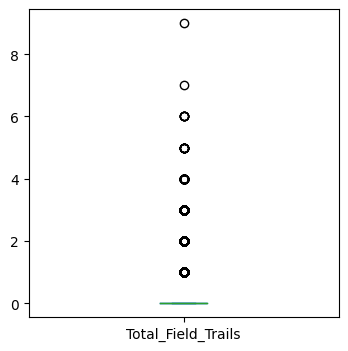

<Figure size 400x400 with 0 Axes>

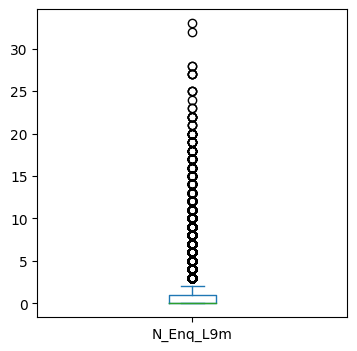

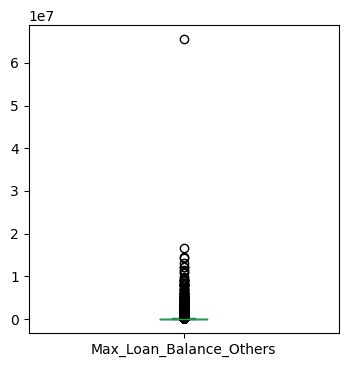

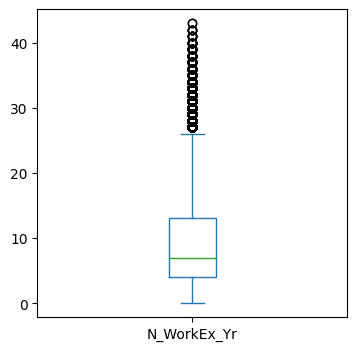

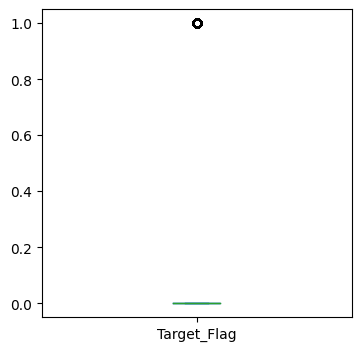

In [191]:
for col in df.columns:
    plt.figure(figsize=(4,4))
    if df[col].dtype != 'O':
        df[col].plot(kind='box')

In [192]:
df.loc[df['Total_Field_Trails'] >= 6, ['Target_Flag','Total_Field_Trails'] ]


,Target_Flag,Total_Field_Trails
Customer_No,,
6493,0,6.0
28708,0,6.0
28986,1,6.0
29239,1,9.0
36039,0,6.0
40763,0,7.0
41244,0,6.0
41977,0,6.0


In [193]:
df.loc[df['N_Enq_L9m'] >= 24, ['Target_Flag'] ].value_counts()


Target_Flag
0              11
1               1
dtype: int64

In [194]:
df.loc[df['Perc_Paymode_Online'] >= 0.6, ['Target_Flag'] ].value_counts()

Target_Flag
0              8
dtype: int64

In [195]:
df.loc[df['Max_Loan_Balance_Others'] >= 6000000, ['Target_Flag'] ].value_counts()

Target_Flag
0              28
1               6
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


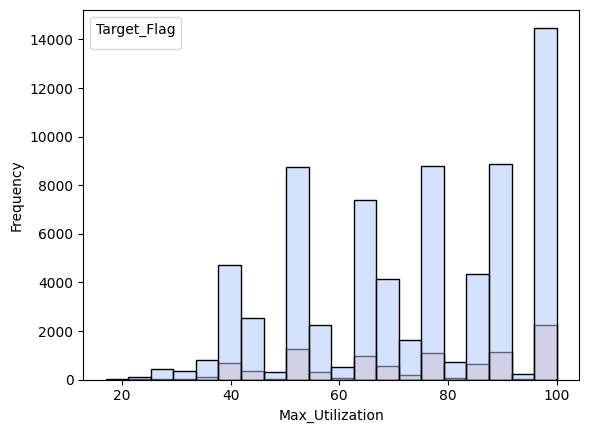

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a histogram with color mapping based on 'Target_Flag'
sns.histplot(data=df, x='Max_Utilization', hue='Target_Flag', bins=20, palette='coolwarm')

# Add labels to the axes
plt.xlabel('Max_Utilization')
plt.ylabel('Frequency')

# Add a legend
plt.legend(title='Target_Flag')

# Show the plot
plt.show()


ABOVE DATA IS MISLEADING REMOVE THESE

In [197]:
df = df[df['Total_Field_Trails'] < 6]


In [198]:
df = df[df['N_Enq_L9m'] < 24]

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81233 entries, 1 to 81253
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   N_Default_L3m             81233 non-null  int64  
 1   Max_Utilization           81233 non-null  int64  
 2   Max_Perc_Def_Chg_Pending  81233 non-null  object 
 3   N_Family_Member           81233 non-null  int64  
 4   Max_Ratio_OC_Pending_POS  81233 non-null  object 
 5   N_PosBkt_L3m              81233 non-null  float64
 6   Ever_Default_L12M         81233 non-null  int64  
 7   Perc_Paymode_Online       81233 non-null  float64
 8   Perc_Repay_Fail           81233 non-null  float64
 9   Birth_Year                81233 non-null  int64  
 10  Max_DPD_L3m               81233 non-null  float64
 11  Perc_Paymode_Cheq_Fail    81233 non-null  float64
 12  Age                       81233 non-null  int64  
 13  Total_Field_Trails        81233 non-null  float64
 14  Total_

In [200]:
df['Max_Ratio_OC_Pending_POS'].unique()

array(['Others', 0.214887321, 0.673447646, ..., 0.052872437, 0.02128042,
       0.043704567], dtype=object)

In [212]:
df['Max_Perc_Def_Chg_Pending'].replace({'None': 0}, inplace=True)

In [214]:
df['Max_Ratio_OC_Pending_POS'].replace({'Others': 0}, inplace=True)

In [203]:
df['Total_Resolved'].unique()
           

array(['None', 0.0, 1.0, 2.0, 3.0], dtype=object)

In [204]:
df['Total_Resolved'].replace({'None': 0}, inplace=True)


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81233 entries, 1 to 81253
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   N_Default_L3m             81233 non-null  int64  
 1   Max_Utilization           81233 non-null  int64  
 2   Max_Perc_Def_Chg_Pending  81233 non-null  float64
 3   N_Family_Member           81233 non-null  int64  
 4   Max_Ratio_OC_Pending_POS  81233 non-null  object 
 5   N_PosBkt_L3m              81233 non-null  float64
 6   Ever_Default_L12M         81233 non-null  int64  
 7   Perc_Paymode_Online       81233 non-null  float64
 8   Perc_Repay_Fail           81233 non-null  float64
 9   Birth_Year                81233 non-null  int64  
 10  Max_DPD_L3m               81233 non-null  float64
 11  Perc_Paymode_Cheq_Fail    81233 non-null  float64
 12  Age                       81233 non-null  int64  
 13  Total_Field_Trails        81233 non-null  float64
 14  Total_

In [206]:
df['Max_Ratio_OC_Pending_POS'].unique()

array(['Others', 0.214887321, 0.673447646, ..., 0.052872437, 0.02128042,
       0.043704567], dtype=object)

One Hot Encoding

In [207]:
for col in categorical_cols:
    df[col] = df[col].astype('object')
    print(df[col].unique())


[3 1 0 2]
[5 1 3 0 11 2 7 4 9 6 10 8]
[0.0 1.0 2.0 3.0]
[1 0]
[0.0 1.0 3.0 2.0 4.0 5.0]
[0.0 1.0 2.0 3.0]


In [208]:
for col in categorical_cols:
    if df[col].dtype == 'object':
        df = pd.get_dummies(df, columns=[col], drop_first=True)

In [215]:
df.head()

,Max_Utilization,Max_Perc_Def_Chg_Pending,Max_Ratio_OC_Pending_POS,Perc_Paymode_Online,Perc_Repay_Fail,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,N_Enq_L9m,...,N_PosBkt_L3m_3.0,Ever_Default_L12M_1,Total_Field_Trails_1.0,Total_Field_Trails_2.0,Total_Field_Trails_3.0,Total_Field_Trails_4.0,Total_Field_Trails_5.0,Total_Resolved_1.0,Total_Resolved_2.0,Total_Resolved_3.0
Customer_No,,,,,,,,,,,,,,,,,,,,,
1,38,100.0,0.0,0.285714,0.428571,1977,19.0,0.750,46,0,...,0,1,0,0,0,0,0,0,0,0
2,68,100.0,0.0,0.000000,0.200000,1990,2.0,0.500,33,0,...,0,1,0,0,0,0,0,0,0,0
3,39,50.0,0.0,0.200000,0.200000,1995,25.0,1.000,28,1,...,0,1,0,0,0,0,0,0,0,0
4,76,0.0,0.0,0.000000,0.000000,1997,0.0,0.000,26,2,...,0,0,0,0,0,0,0,0,0,0
5,23,33.0,0.0,0.250000,0.250000,1995,19.0,0.375,28,1,...,0,1,0,0,0,0,0,0,0,0


In [210]:
df.head()

,Max_Utilization,Max_Perc_Def_Chg_Pending,Max_Ratio_OC_Pending_POS,Perc_Paymode_Online,Perc_Repay_Fail,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,N_Enq_L9m,...,N_PosBkt_L3m_3.0,Ever_Default_L12M_1,Total_Field_Trails_1.0,Total_Field_Trails_2.0,Total_Field_Trails_3.0,Total_Field_Trails_4.0,Total_Field_Trails_5.0,Total_Resolved_1.0,Total_Resolved_2.0,Total_Resolved_3.0
Customer_No,,,,,,,,,,,,,,,,,,,,,
1,38,100.0,Others,0.285714,0.428571,1977,19.0,0.750,46,0,...,0,1,0,0,0,0,0,0,0,0
2,68,100.0,Others,0.000000,0.200000,1990,2.0,0.500,33,0,...,0,1,0,0,0,0,0,0,0,0
3,39,50.0,Others,0.200000,0.200000,1995,25.0,1.000,28,1,...,0,1,0,0,0,0,0,0,0,0
4,76,0.0,Others,0.000000,0.000000,1997,0.0,0.000,26,2,...,0,0,0,0,0,0,0,0,0,0
5,23,33.0,Others,0.250000,0.250000,1995,19.0,0.375,28,1,...,0,1,0,0,0,0,0,0,0,0


In [211]:
df.to_csv('Preprocessed_01.csv', index=False)